<a href="https://colab.research.google.com/github/calerovillalobos10/Intro_Limpieza_Transf_Data/blob/main/Lab2_PF3347.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 Limpieza y Transformación de Datos

## Estudiantes

*   Bryan Thomas Calero Villalobos
*   Daniela Montero Parkinson
*   Christopher Zúñiga Cárdenas

# Uso práctico

## Extracción de datos

Se ingresa a la página de [OpenQA](https://openaq.org/) para consumir el API que nos da la documentación, en este caso se utilizará para el trabajo el API V3. En la documentación del api se indica registrarse en [Registro](https://explore.openaq.org/register) e ir al apartado de *cuenta*, con el fin de capturar el API KEY necesario para consumir el API.

Como primer paso se instalan las librerías necesarias para poder consumir el API mencionado y capturar las variables de entorno

In [1]:
# Instalar las librerías necesarias
!pip3 install requests
!pip3 install python-dotenv

Se importan las librerías para poder utilizarlas en los métodos definidos

In [2]:
import requests
import os
from dotenv import load_dotenv
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from urllib.parse import urlencode
from datetime import datetime

Se descargar el archivo del .env que se encuentra en drive

In [3]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1JrTQmCwUWuru9BJFCwuG25_aIT1uN4XR' -O .env

--2024-10-20 01:53:39--  https://drive.google.com/uc?export=download&id=1JrTQmCwUWuru9BJFCwuG25_aIT1uN4XR
Resolving drive.google.com (drive.google.com)... 173.194.210.102, 173.194.210.139, 173.194.210.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.210.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1JrTQmCwUWuru9BJFCwuG25_aIT1uN4XR&export=download [following]
--2024-10-20 01:53:39--  https://drive.usercontent.google.com/download?id=1JrTQmCwUWuru9BJFCwuG25_aIT1uN4XR&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.107.132, 2607:f8b0:400c:c32::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79 [application/octet-stream]
Saving to: ‘.env’

.env                100%[===================>]      79  --.-KB/s    in 0s      


Obtener el api key para consumir la información del sitio Open AQ

In [4]:
load_dotenv('.env') # Cargar el archivo .env descargado
API_KEY = os.getenv('KEY_OpenAQ') # Obtener el API KEY de la variable de entorno

Se inicializa una variable con la url a consumir

In [5]:
api_url = f'https://api.openaq.org/v2/measurements'

Se definen los parámetros que se enviarán al enpoint y mediante este método se construye la url final a consumir

In [6]:
# Construye la URL con los parámetros necesarios
def build_url(country, start_date, end_date, page, limit):
  # Parámetros para la solicitud: país, fechas y página actual
  params = {
    'date_from': start_date,
    'date_to': end_date,
    'limit': limit,  # Ajusta el límite según lo necesario
    'page': page,
    'country': country,
    'sort': 'desc',
    'order_by': 'datetime'
  }

  return f"{api_url}?{urlencode(params)}"

Este método se implementó para solucionar el problema Request Time-out que arroja el api, dado a la cantidad de información que trae. Se funcionalidad es crear una sesión HTTP que aplica reintentos automáticos cuando se producen errores temporales o de conexión en solicitudes GET

In [7]:
# Método para crear la estrategia de reintentos
def create_retry_session(max_retries):
    retry_strategy = Retry(
        total=max_retries,  # Número máximo de reintentos
        status_forcelist=[408, 500, 502, 503, 504],  # Errores a los que se aplicarán los reintentos
        allowed_methods=["GET"],  # Solo reintentar en solicitudes GET
        backoff_factor=1  # Tiempo de espera entre reintentos
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)

    # Crear una sesión de requests con el adaptador de reintentos
    http = requests.Session()
    http.mount("https://", adapter)

    return http  # Devolver la sesión con la estrategia de reintentos

El siguiente método consume el API utilizando requests, obteniendo los datos de los países que proporciona la web. Este retorna una lista de diccionarios sobre los países con el método .json() utilizado en la línea data = response.json()

In [8]:
# Obtiene los datos de cada país
def fetch_country_data(country, start_date, end_date, limit, max_retries=1):
  all_data = [] # Lista para almacenar los datos obtenidos de todas las páginas

  try:

    page = 1  # Se inicia en la primera página
    has_more_data = True  # Control para el bucle
    headers = {"accept": "application/json", "X-API-Key": API_KEY} # Encabezados de la solicitud, incluyendo la API Key

    # Usar el nuevo método para crear la sesión con reintentos
    http = create_retry_session(max_retries)

    # Bucle para hacer solicitudes mientras haya más datos disponibles
    while has_more_data:
      # Crear la URL con los parámetros del país, fechas, página y límite
      url = build_url(country, start_date, end_date, page, limit)

      response = http.get(url, headers=headers) # Realiza la solicitud HTTP al API
      response.raise_for_status() # Lanza un error si la respuesta no es exitosa

      data = response.json().get('results', [])
      all_data.extend(data)  # Añade los datos de la página actual a la lista general

      if len(data) < limit:
        print(f"{country} No más datos")
        has_more_data = False # Si no hay más datos, se finaliza el bucle
      else:
        page += 1  # Si hay más datos, avanzar a la siguiente página

  except requests.RequestException as e:
    print(f"{country} No más datos")

  return all_data

La siguiente función obtiene datos de varios países en un rango de fechas específico y con un límite de resultados por país. Recorre una lista de países, llama a la función fetch_country_data para cada uno, y si se obtienen datos, los almacena en una lista que finalmente retorna.

In [9]:
# Función para obtener los datos de varios países
def get_countries_data(countries, start_date, end_date, limit):

  all_data = [] # Lista para almacenar todos los datos obtenidos

  # Ciclo sobre la lista de países
  for country in countries:

    print(f"Obteniendo datos para {country}...")
    # Llamada a una función que obtiene los datos del país en un periodo específico
    data = fetch_country_data(country, start_date, end_date, limit)

    if any(data):
      all_data.extend(data) # si existen datos se añaden los resultados a la lista general

  return all_data

Parámetros para definir los datos que se quieren obtener del api de open qa

In [10]:
# Parámetros para el enpoint
countries = ['CR', 'BE', 'DE', 'PE', 'AR', 'US']  # Costa Rica, Belgica, Alemania , Peru, Argentina, Estados Unidos

start_date = '2014-01-01T00:00:00Z'
end_date = datetime.utcnow().isoformat() + "Z"

data = get_countries_data(countries, start_date, end_date, 15000)

Obteniendo datos para CR...
CR No más datos
Obteniendo datos para BE...
BE No más datos
Obteniendo datos para DE...
DE No más datos
Obteniendo datos para PE...
PE No más datos
Obteniendo datos para AR...
AR No más datos
Obteniendo datos para US...
US No más datos


## Análisis EDA Exploratorio

### Descripción del conjunto de datos
El conjunto de datos recuperados desde el API contiene casi 500,000  filas y 15 columnas. En esta información recuperada se identificó algunos parámetros de interés:
* locationId: y location los cuales son parámetros que funcionan para identificar ubicaciones.
* parameter: el cuál es un indicador para los tipos de parámetros medidos (como pm25, co, no2, o3, pm10, pm25, so2).
* value: el cual es el parámetro que trae valores de las mediciones.
* unit: Son las unidades de medición (microgramos por metro cúbico, µg/m³).
* coordinates.latitude y coordinates.longitude: los cuales son parámetros para la ubicación geográfica de las mediciones.




### Columnas con valores nulos o problemáticos
* city,  isAnalysis y isMobile: son columnas que vienen completamente vacías, dado a los países que se seleccionaron para la revisión. Estas columnas podrían eliminarse si no son útiles.
* sensorType y entity: en todas las filas vienen con un mismo.
* value: tiene valores problemáticos como -999.0, lo cual probablemente represente datos faltantes. Estos deben corregirse o imputarse adecuadamente.



### Detección de valores atípicos en las mediciones
Dentro de la columna value se detectaron valores atípicos (outliers) lo cual indica la presencia de valores “extremos” lo que podría afectar en el análisis de los datos.



### Análisis de los parámetros medidos (parameter)
Se debe analizar la distribución de los diferentes parámetros medidos, como PM25, NO2, CO, entre otros. Con el fin de entender mejor qué contaminantes se monitorean con mayor frecuencia.


#### Preguntas clave:
* ¿Qué parámetros de calidad del aire son los más comunes en el conjunto de datos?
* ¿Cómo varían los valores de estos parámetros en diferentes ubicaciones?

## Limpieza de datos y Transformación

Esta limpieza de datos si realizó siguiendo pasos de las guías de Guzman (2022) y Rcurioso (s.f.). En donde se explican ciertos prácticas y métodos de pandas para poder realziar un análisis y limpieza de forma más detallada

Se importan librerías necesarias y se asigna la data a otra variable para manipular sin tocar los datos originales

In [11]:
import pandas as pd
from pandas import json_normalize

# Normalizar los datos
df_results = data

Se inicia la exploración de datos para empezar a limpiar data

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Se transforman los datos a un DataFrame para una mejora manipulación de los datos

In [13]:
datos = pd.DataFrame(df_results)

Se hace un .head para empezar a familiarizar con los datos

In [14]:
print(f'Descripcion Data: ')
datos.head() #muestra de los primeros 5 registros

Descripcion Data: 


,locationId,location,parameter,value,date,unit,coordinates,country,city,isMobile,isAnalysis,entity,sensorType
0,7077,US Diplomatic Post: San Jose,pm25,-999.0,"{'utc': '2024-10-20T01:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 9.949488, 'longitude': -84.142876}",CR,None,False,None,Governmental Organization,reference grade
1,7077,US Diplomatic Post: San Jose,pm25,-999.0,"{'utc': '2024-10-20T00:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 9.949488, 'longitude': -84.142876}",CR,None,False,None,Governmental Organization,reference grade
2,7077,US Diplomatic Post: San Jose,pm25,-999.0,"{'utc': '2024-10-19T23:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 9.949488, 'longitude': -84.142876}",CR,None,False,None,Governmental Organization,reference grade
3,7077,US Diplomatic Post: San Jose,pm25,-999.0,"{'utc': '2024-10-19T22:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 9.949488, 'longitude': -84.142876}",CR,None,False,None,Governmental Organization,reference grade
4,7077,US Diplomatic Post: San Jose,pm25,-999.0,"{'utc': '2024-10-19T21:00:00+00:00', 'local': ...",µg/m³,"{'latitude': 9.949488, 'longitude': -84.142876}",CR,None,False,None,Governmental Organization,reference grade


Como se detectaron datos anidados (dict) se realiza la siguiente normalización y condición para separa los datos en nuevas columnas

In [15]:
# Normalizar los datos
datos_normalizados = json_normalize(df_results)

# Si hay parámetros anidados dentro de los resultados, normalizarlos también
if 'parameters' in datos_normalizados.columns:
  df_parameters = json_normalize(datos_normalizados['parameters'].explode())
  datos_normalizados = datos_normalizados.drop(columns=['parameters']).join(df_parameters, rsuffix='_param')

Se vuelve a imprimir el dataframe para visualizar las nuevas columas

In [16]:
datos = pd.DataFrame(datos_normalizados)
datos.head()

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,date.utc,date.local,coordinates.latitude,coordinates.longitude
0,7077,US Diplomatic Post: San Jose,pm25,-999.0,µg/m³,CR,None,False,None,Governmental Organization,reference grade,2024-10-20T01:00:00+00:00,2024-10-19T19:00:00-06:00,9.949488,-84.142876
1,7077,US Diplomatic Post: San Jose,pm25,-999.0,µg/m³,CR,None,False,None,Governmental Organization,reference grade,2024-10-20T00:00:00+00:00,2024-10-19T18:00:00-06:00,9.949488,-84.142876
2,7077,US Diplomatic Post: San Jose,pm25,-999.0,µg/m³,CR,None,False,None,Governmental Organization,reference grade,2024-10-19T23:00:00+00:00,2024-10-19T17:00:00-06:00,9.949488,-84.142876
3,7077,US Diplomatic Post: San Jose,pm25,-999.0,µg/m³,CR,None,False,None,Governmental Organization,reference grade,2024-10-19T22:00:00+00:00,2024-10-19T16:00:00-06:00,9.949488,-84.142876
4,7077,US Diplomatic Post: San Jose,pm25,-999.0,µg/m³,CR,None,False,None,Governmental Organization,reference grade,2024-10-19T21:00:00+00:00,2024-10-19T15:00:00-06:00,9.949488,-84.142876


Esta línea de código devuelve el análisis de la tabla para exploración

In [17]:
# inicio de analisis y limpieza
print(f'Descripción Data: ')# devuelve el analisis de la tabla para exploracion el mismo devuelve: promedio, conteo, min, max , persentiles 25/50/75 y desviacion estandar por cada variable
datos.describe()

Descripción Data: 


,locationId,value,coordinates.latitude,coordinates.longitude
count,4.280850e+05,428085.000000,428085.000000,428085.000000
mean,9.829304e+03,-14.822339,20.015881,-42.414615
std,1.425274e+05,176.610900,33.252215,43.574707
min,1.610000e+02,-999.000000,-34.625270,-95.756601
25%,8.190000e+02,0.032000,-12.026111,-84.142876
50%,3.126000e+03,5.200000,29.723300,-58.365550
75%,5.240000e+03,18.000000,49.628700,5.630398
max,3.070644e+06,1380.000000,53.559784,14.525960


La siguiente línea de código nos dice el tipo de dato por columna y cantidad de nulos

In [18]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428085 entries, 0 to 428084
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   locationId             428085 non-null  int64  
 1   location               428085 non-null  object 
 2   parameter              428085 non-null  object 
 3   value                  428085 non-null  float64
 4   unit                   428085 non-null  object 
 5   country                428085 non-null  object 
 6   city                   0 non-null       object 
 7   isMobile               428085 non-null  bool   
 8   isAnalysis             0 non-null       object 
 9   entity                 428085 non-null  object 
 10  sensorType             428085 non-null  object 
 11  date.utc               428085 non-null  object 
 12  date.local             428085 non-null  object 
 13  coordinates.latitude   428085 non-null  float64
 14  coordinates.longitude  428085 non-nu

la siguiente línea ayuda para visualizar datos en null

In [19]:
datos.isnull()

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,date.utc,date.local,coordinates.latitude,coordinates.longitude
0,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428080,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
428081,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
428082,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False
428083,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False


La siguiente línea devuelve la cantidad de nulos

In [20]:
datos.isnull().sum()

,0
locationId,0
location,0
parameter,0
value,0
unit,0
country,0
city,428085
isMobile,0
isAnalysis,428085
entity,0


Esta porción de código lo que permite es identificar cuáles columnas se mantendrán para el análisis de los datos. Al ejecutar esta lógica se identifica que hay columnas con 0 subniveles, lo cual quiere decir que se pueden eliminar debido a que contienen solo datos nulos, y las que tienen solo 1 nivel constan de solo un mismo dato (repetido a lo largo de las filas) por lo que, para el análisis, no se hacen relevantes este tipo de columnas

In [21]:
#inicio deteccion de niveles
cols_cat = datos.columns.tolist() # se capturan los nombres de las columnas del DF

# se inicializa un array para capturar las columnas que se descartarán por poca relevancia
col_descartadas = []

#Con este fragmento de codigo nos damos cuanta cuantos subniveles tiene cada columna, esto nos ayuda a ver cuales son las variables finales para la data
for col in cols_cat:
  print(f'Columna {col}: {datos[col].nunique()} subniveles')

  if(datos[col].nunique() <= 1):
    col_descartadas.append(col)

Columna locationId: 50 subniveles
Columna location: 50 subniveles
Columna parameter: 6 subniveles
Columna value: 22806 subniveles
Columna unit: 2 subniveles
Columna country: 6 subniveles
Columna city: 0 subniveles
Columna isMobile: 1 subniveles
Columna isAnalysis: 0 subniveles
Columna entity: 2 subniveles
Columna sensorType: 2 subniveles
Columna date.utc: 72015 subniveles
Columna date.local: 152020 subniveles
Columna coordinates.latitude: 50 subniveles
Columna coordinates.longitude: 50 subniveles


Al haber detectado las columnas menos relevantes o que no serán útiles se eliminan para optimizar o reducir la carga de procesamiento al realizar el respectivo análisis o sus visualizaciones

In [22]:
# luego de notar que las columnas city, isMobile, isAnalysis, entity, sensorType tienen 1 o 0 subniveles y se deciden eliminar de la data
datos.drop(columns=col_descartadas, inplace=True) # Con inplace=True: modifica datos directamente, sin crea un dataframe nuevo

La siguiente celda se utiliza para detectar cuántos duplicados hay en los datos y eliminarlos si se encuentran

In [23]:
# Inicio duplicados
duplicados = datos.duplicated().sum() #contar datos duplicados

#Elimina los duplicados si es que los hay
if duplicados > 1:
  print(f'Tamaño previo: {datos.shape}')
  datos.drop_duplicates(inplace=True)
  print(f'Tamaño posterior: {datos.shape}')
else:
  print('No hay filas duplicadas')

No hay filas duplicadas


Se eliminan los espacios para mantener un estandar y buenas prácticas de limpieza, ya que hay datos que pueden tener espacios que evitan el poder realizar un cruce de datos

In [24]:
# Eliminar espacios al principio y al final en todas las columnas de texto
datos['location'] = datos['location'].str.strip()
datos['parameter'] = datos['parameter'].str.strip()
datos['unit'] = datos['unit'].str.strip()
datos['country'] = datos['country'].str.strip()

Se aplica un histograma para revisar outliers

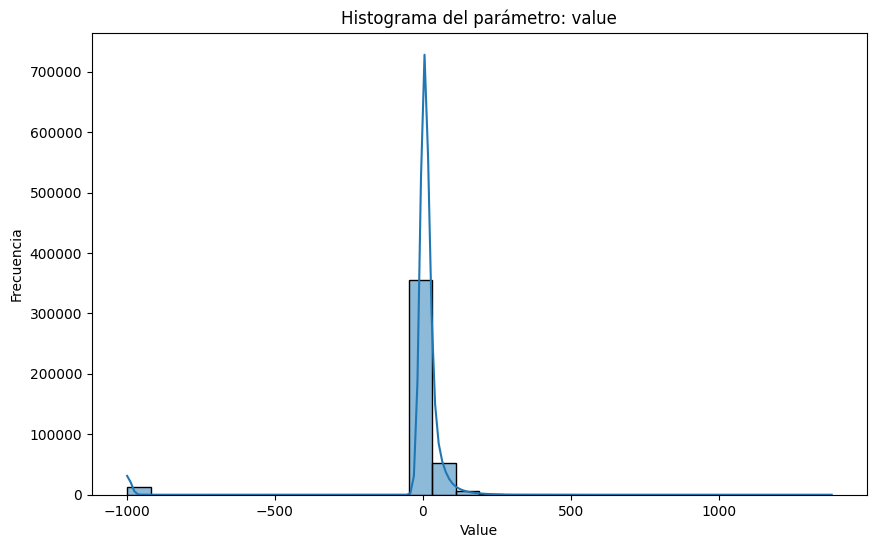

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(data=datos, x='value', bins=30, kde=True)  # kde=True añade una curva de densidad
plt.title('Histograma del parámetro: value')
plt.xlabel('Value')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

En esta porción de código se visualizan los datos y se detecta que solo la variable *value* tiene datos muy bajos o muy altos (atípicos). El más repetido es el -999, el cual se entiende como un valor atípico

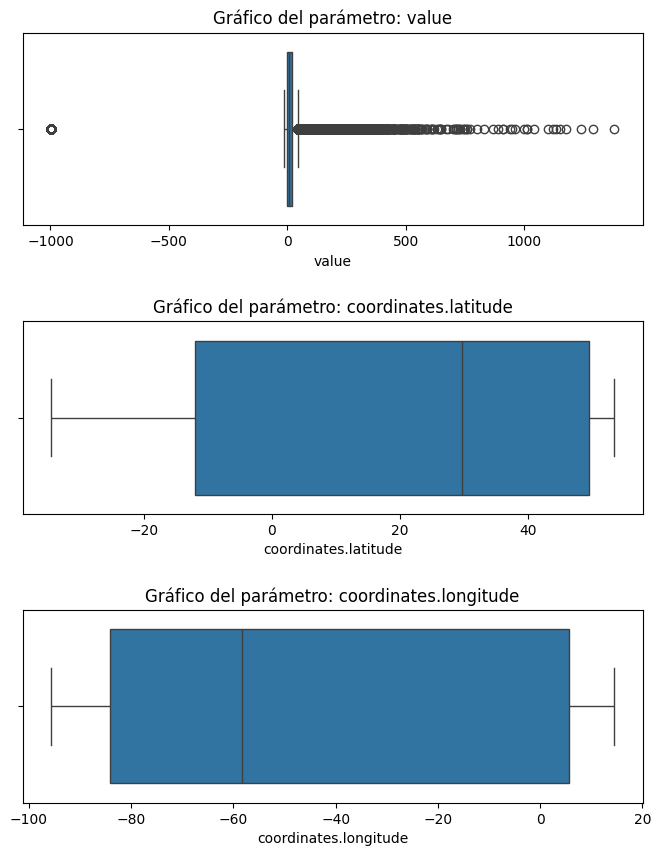

In [26]:
#revision de outliers en variables numericas
cols_num = ['value', 'coordinates.latitude', 'coordinates.longitude']

# Define la estructura del gráfico
fig, ax = plt.subplots(nrows = len(cols_num), ncols = 1, figsize = (8,10))
fig.subplots_adjust(hspace = 0.5) # Espacio entre gráficos

for i, col in enumerate(cols_num):
    sns.boxplot(x = col, data = datos, ax = ax[i]) # información para crear el gráfico
    ax[i].set_title(f'Gráfico del parámetro: {col}') # Nombre del gráfico

plt.show() # Muestra el gráfico

Se realiza una revisión del minimo y máximo del parámetro que se identificó con posibles sesgos

In [27]:
maximo_valor = datos.value.max()
ultimo_valor = datos.value.min()
print(f'Datos menor: {ultimo_valor}')
print(f'Datos mayor: {maximo_valor}')

Datos menor: -999.0
Datos mayor: 1380.0


Revisamos la cantidad de registros el dataframe antes de aplicar la función de limipeza de cuartiles

In [28]:
num_filas = datos.shape[0]
print(f'Cantidad de filas: {num_filas}')

Cantidad de filas: 428085


Se utiliza el método quantile para eliminar los outliners

In [29]:
# Calcular los cuartiles
Q1 = datos['value'].quantile(0.25)
Q3 = datos['value'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar los outliers
datos = datos[(datos['value'] >= limite_inferior) & (datos['value'] <= limite_superior)]

Se revisa la cantidad de registros después de aplicado el zscore

In [30]:
num_filas = datos.shape[0]
print(f'Cantidad de filas: {num_filas}')

Cantidad de filas: 375016


Se limpian las variables con tipos de datos no acordes a lo esperado, se obtiene los tipos con .info() para saber cuales se deben cambiar

In [31]:
datos['date.utc'] = pd.to_datetime(datos['date.utc'],utc=True)
datos['date.local'] = pd.to_datetime(datos['date.local'], utc=True)
datos.info() # verificar cambios de variables
datos

<class 'pandas.core.frame.DataFrame'>
Index: 375016 entries, 6345 to 428084
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   locationId             375016 non-null  int64              
 1   location               375016 non-null  object             
 2   parameter              375016 non-null  object             
 3   value                  375016 non-null  float64            
 4   unit                   375016 non-null  object             
 5   country                375016 non-null  object             
 6   entity                 375016 non-null  object             
 7   sensorType             375016 non-null  object             
 8   date.utc               375016 non-null  datetime64[ns, UTC]
 9   date.local             375016 non-null  datetime64[ns, UTC]
 10  coordinates.latitude   375016 non-null  float64            
 11  coordinates.longitude  375016 non-null  f

,locationId,location,parameter,value,unit,country,entity,sensorType,date.utc,date.local,coordinates.latitude,coordinates.longitude
6345,7077,US Diplomatic Post: San Jose,pm25,9.000,µg/m³,CR,Governmental Organization,reference grade,2023-09-13 23:00:00+00:00,2023-09-13 23:00:00+00:00,9.949488,-84.142876
6346,7077,US Diplomatic Post: San Jose,pm25,9.000,µg/m³,CR,Governmental Organization,reference grade,2023-09-13 22:00:00+00:00,2023-09-13 22:00:00+00:00,9.949488,-84.142876
6347,7077,US Diplomatic Post: San Jose,pm25,17.000,µg/m³,CR,Governmental Organization,reference grade,2023-09-13 21:00:00+00:00,2023-09-13 21:00:00+00:00,9.949488,-84.142876
6348,7077,US Diplomatic Post: San Jose,pm25,13.000,µg/m³,CR,Governmental Organization,reference grade,2023-09-13 20:00:00+00:00,2023-09-13 20:00:00+00:00,9.949488,-84.142876
6349,7077,US Diplomatic Post: San Jose,pm25,10.000,µg/m³,CR,Governmental Organization,reference grade,2023-09-13 19:00:00+00:00,2023-09-13 19:00:00+00:00,9.949488,-84.142876
...,...,...,...,...,...,...,...,...,...,...,...,...
428080,173,Houston Westhollow C,o3,0.014,ppm,US,Governmental Organization,reference grade,2016-06-15 09:00:00+00:00,2016-06-15 09:00:00+00:00,29.723300,-95.635800
428081,173,Houston Westhollow C,o3,0.014,ppm,US,Governmental Organization,reference grade,2016-06-15 08:00:00+00:00,2016-06-15 08:00:00+00:00,29.723300,-95.635800
428082,173,Houston Westhollow C,o3,0.014,ppm,US,Governmental Organization,reference grade,2016-06-15 07:00:00+00:00,2016-06-15 07:00:00+00:00,29.723300,-95.635800
428083,173,Houston Westhollow C,o3,0.015,ppm,US,Governmental Organization,reference grade,2016-06-15 05:00:00+00:00,2016-06-15 05:00:00+00:00,29.723300,-95.635800


Se vuelven a graficar los datos para ver la diferencia al eliminar los outliers

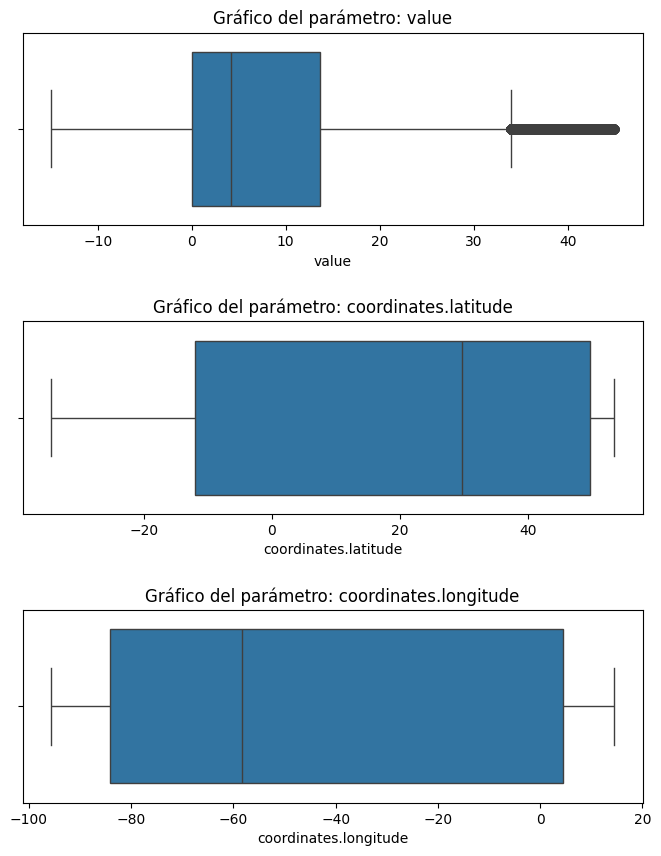

In [32]:
#revision de outliers en variables numericas
cols_num = ['value', 'coordinates.latitude', 'coordinates.longitude']

# Define la estructura del gráfico
fig, ax = plt.subplots(nrows = len(cols_num), ncols = 1, figsize = (8,10))
fig.subplots_adjust(hspace = 0.5) # Espacio entre gráficos

for i, col in enumerate(cols_num):
    sns.boxplot(x = col, data = datos, ax = ax[i]) # información para crear el gráfico
    ax[i].set_title(f'Gráfico del parámetro: {col}') # Nombre del gráfico

plt.show() # Muestra el gráfico

La siguiente porción de código se utiliza para identificar outliers en las columnas de tipo categoría. Esto con el fin de detectar, por ejemplo: mayúsculas, minúscualas, tildes dentro de las mismas categorías. Además, se grafican los parámetros de categorías con el fin de identicar si hay algún dato que necesita ser unificado, por nombre con mayúsculas o minúsculas

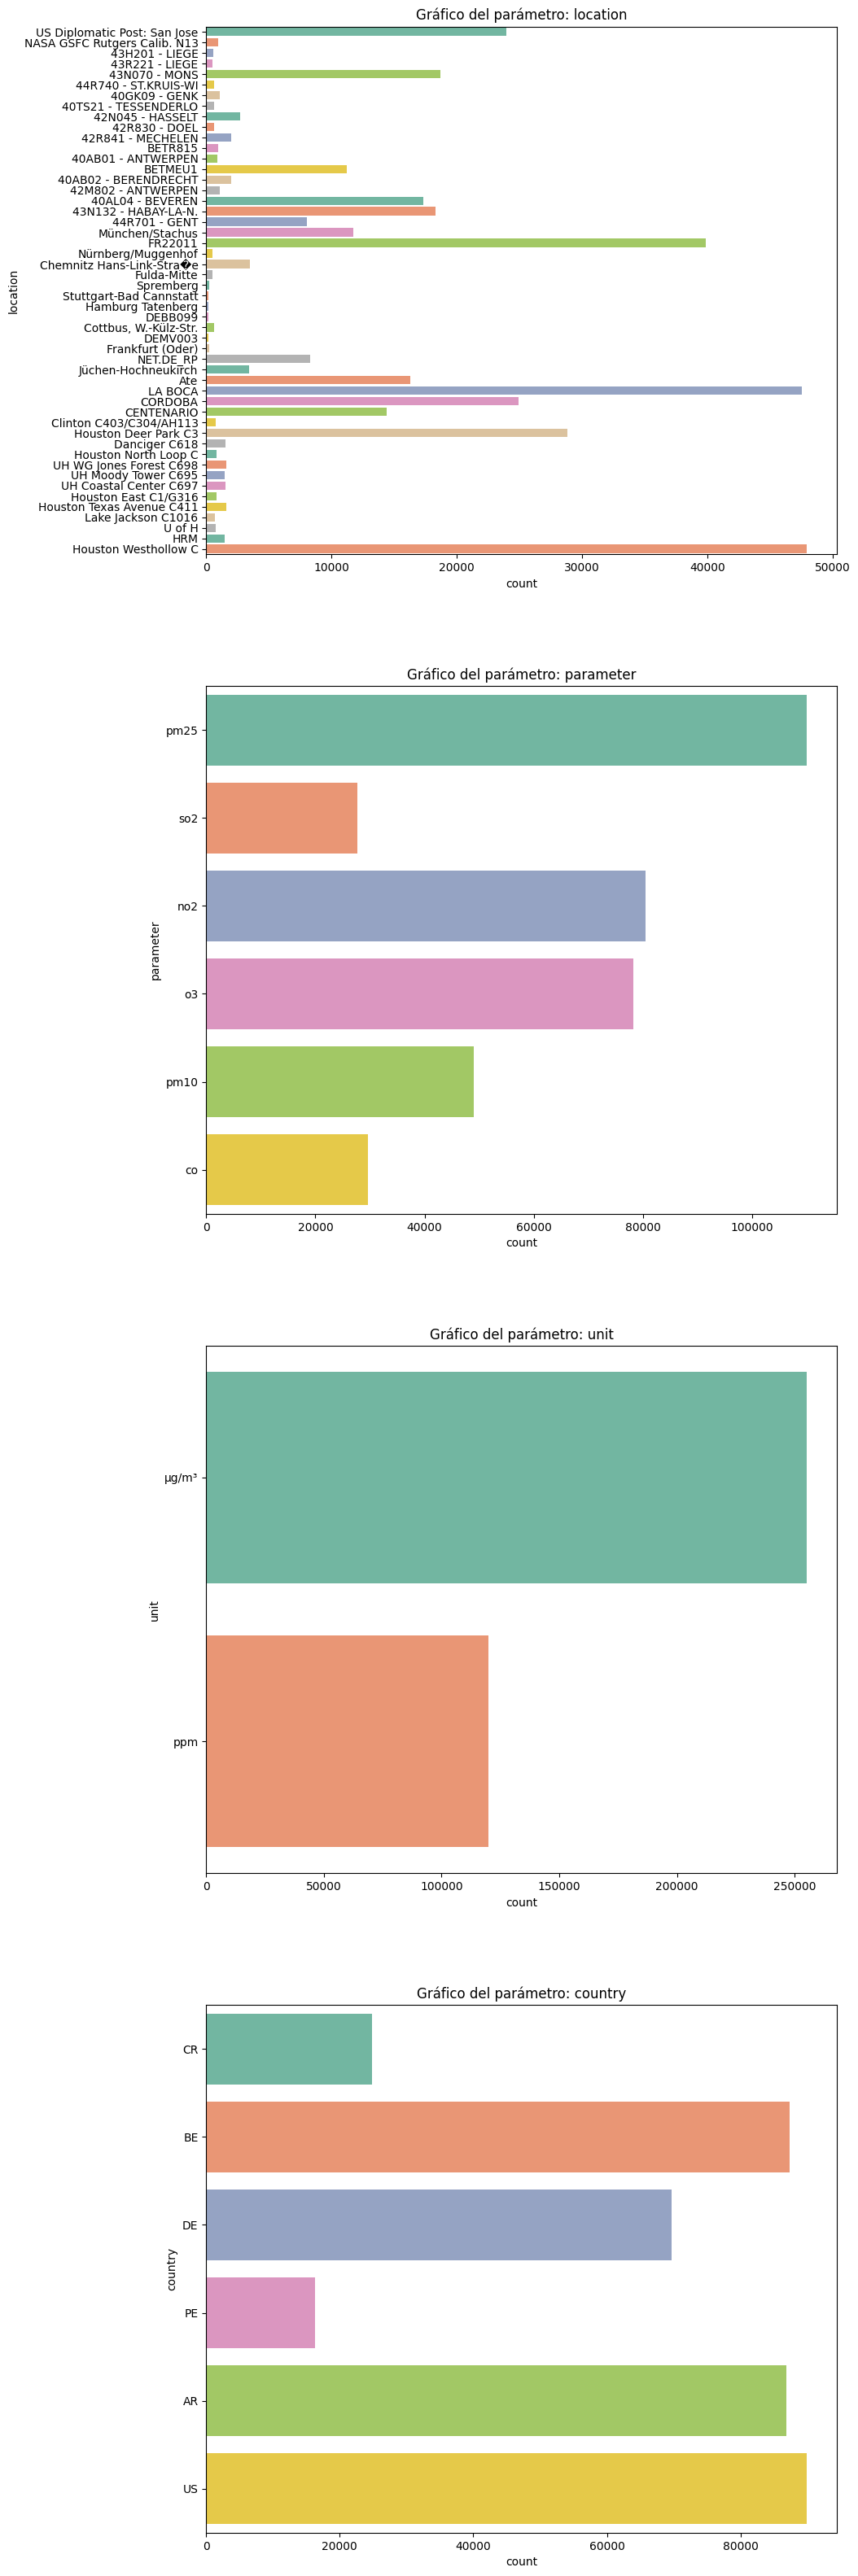

In [33]:
# Graficar los subniveles de cada variable categórica para identificar outliers
# Lista de columnas categóricas
cols_cat = ['location', 'parameter', 'unit', 'country']

# Crear figura y ejes
fig, ax = plt.subplots(nrows=len(cols_cat), ncols=1, figsize=(10, 10 * len(cols_cat)))
fig.subplots_adjust(hspace=0.25)  # Ajustar espacio entre subplots

# Iterar por cada columna categórica
for i, col in enumerate(cols_cat):
    sns.countplot(y=col, data=datos, ax=ax[i], hue=col, palette='Set2')
    ax[i].set_title(f'Gráfico del parámetro: {col}')

    # Usar plt.xticks() para rotar etiquetas sin problemas de locators
    ax[i].tick_params(axis='y', rotation=0)

# Mostrar el gráfico
plt.show()

Luego de evaluar errores tipográficos en variables categóricas no se detectaron valores atípicos, en la data. Aunque se implementó un estandar de utilizar todos los datos en mayúsculas de los datos, con el fin de graficar con mayor facilidad

In [34]:
# Se aplica upper para que todos los valores tengan un estandar
datos['location'] = datos['location'].str.upper()
datos['parameter'] = datos['parameter'].str.upper()
datos['unit'] = datos['unit'].str.upper()
datos['country'] = datos['country'].str.upper()

datos.head()

,locationId,location,parameter,value,unit,country,entity,sensorType,date.utc,date.local,coordinates.latitude,coordinates.longitude
6345,7077,US DIPLOMATIC POST: SAN JOSE,PM25,9.0,ΜG/M³,CR,Governmental Organization,reference grade,2023-09-13 23:00:00+00:00,2023-09-13 23:00:00+00:00,9.949488,-84.142876
6346,7077,US DIPLOMATIC POST: SAN JOSE,PM25,9.0,ΜG/M³,CR,Governmental Organization,reference grade,2023-09-13 22:00:00+00:00,2023-09-13 22:00:00+00:00,9.949488,-84.142876
6347,7077,US DIPLOMATIC POST: SAN JOSE,PM25,17.0,ΜG/M³,CR,Governmental Organization,reference grade,2023-09-13 21:00:00+00:00,2023-09-13 21:00:00+00:00,9.949488,-84.142876
6348,7077,US DIPLOMATIC POST: SAN JOSE,PM25,13.0,ΜG/M³,CR,Governmental Organization,reference grade,2023-09-13 20:00:00+00:00,2023-09-13 20:00:00+00:00,9.949488,-84.142876
6349,7077,US DIPLOMATIC POST: SAN JOSE,PM25,10.0,ΜG/M³,CR,Governmental Organization,reference grade,2023-09-13 19:00:00+00:00,2023-09-13 19:00:00+00:00,9.949488,-84.142876


## Análisis EDA luego de limpieza

En la limpieza y transformación de datos se fueron realizando ciertos pasos los cuales se implementaron pensando en el análisis EDA. Dado que al ir haciendo la limpieza se fueron analizando los datos de forma sistemática y esto ayudó a generar el propio EDA. A continuación se presenta de forma seccionada un resumen lo encontrado con los datos que se están tratando con el fin de comprender la estructura, detectar patrones, detectar outliers y formular hipótesis

### Entender la estructura de los datos

Basados en la documentación de pandas (2024), para poder entender la estructura de los datos se utilizaron métodos de pandas como los siguientes:
* *datos.head()*: se utilizó para visualizar las primeras filas del dataframe y así poder visualizar qué tipo de datos venían en cada columna y su distribución
* *datos.info()*: este se utilizó para identificar el tipo de dato de cada columna e identificar si habían muchas columnas con dato tipo object, ya que esto nos permitía analizar si los datos tenían posibilidad de venir corruptos en ciertas columnas. Dado que si con el .head() se veían datos numéricos, pero el .info() marcaba object podíamos inferir que talvez hayan datos de otro tipo y posiblemente hay que hacer una depuración de datos en esas columnas
* *datos.describe()*: este se utilizó para ver las estadísitcias resumidas de las variables. Este resumen estadístico nos dio la tabla que retornaba: promedio, conteo, min, max , persentiles 25/50/75 y desviacion estandar por cada variable. En donde se identificaron outliers con el min y el max en el parametro *value*. Además, se encontró que:
  * locationId: parecen ser valores numéricos
  * value: la media es -15.2 lo que puede sugerir valores sesgdos y el valor máximo es 1380 lo que muestra una dispersión de datos bastante grande

Segúne esta revisión de datos se identificó la necesidad de normalización de los mismo debido a que la mayoría de varibles tienen un rango amplio y se detecto que en ciertas columnas los datos venían en un tipo JSON o diccionario.

Al detectar esto se aplicó una normalización y separación de las columnas de tipo dict en nuevas columnas:



```
# Normalizar los datos
datos_normalizados = json_normalize(df_results)

# Si hay parámetros anidados dentro de los resultados, normalizarlos también
if 'parameters' in datos_normalizados.columns:
  df_parameters = json_normalize(datos_normalizados['parameters'].explode())
  datos_normalizados = datos_normalizados.drop(columns=['parameters']).join(df_parameters, rsuffix='_param')
```



### Detección de valores atípicos (outliers)

La detección de outliers se realizó incialmente con el método .describe() de pandas (pandas, 2024) y también mediante un gráfico de caja, para detectar si habían datos muy "extremos":

```
#revision de outliers en variables numericas
cols_num = ['value', 'coordinates.latitude', 'coordinates.longitude']

# Define la estructura del gráfico
fig, ax = plt.subplots(nrows = len(cols_num), ncols = 1, figsize = (8,10))
fig.subplots_adjust(hspace = 0.5) # Espacio entre gráficos

for i, col in enumerate(cols_num):
    sns.boxplot(x = col, data = datos, ax = ax[i]) # información para crear el gráfico
    ax[i].set_title(f'Gráfico del parámetro: {col}') # Nombre del gráfico

plt.show() # Muestra el gráfico
```
Este gráfico que se integró en la limpieza de datos (para el entendimiento de próximas limpiezas o transformaciones de datos) demostró que había una clara diferencia en los datos del parámetro *value*, por lo que para reducir o eliminar estos outliers se aplicó una fórmula de cuartiles basados en la lectura de Castrillo (2024). En donde se eligió esta metología ya que se adaptaba mejor a los datos que se están analizando.



```
# Calcular los cuartiles
Q1 = datos['value'].quantile(0.25)
Q3 = datos['value'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar los outliers
datos = datos[(datos['value'] >= limite_inferior) & (datos['value'] <= limite_superior)]
```

El aplicar esta metodología para la eliminación de los outliners permitió visualizar de mejor manera la media de los datos en el gráfico de caja que se ejecutó nuevamente para hacer la comparativa e identificar la diferencia de datos, al haber realizado una limpieza de datos sesgados.


Además, se realizó otras gráficas (en este caso de barras) para identificar si las columnas de categorías tenían ouliers. Esto con la finalidad de detectar si habían categorías con mayúsculas, minúsculas o tildes. Ya que si se identificaba esta diferencia se podía unificar los valores y evitar un sesgo



```
# Graficar los subniveles de cada variable categórica para identificar outliers
# Lista de columnas categóricas
cols_cat = ['location', 'parameter', 'unit', 'country']

# Crear figura y ejes
fig, ax = plt.subplots(nrows=len(cols_cat), ncols=1, figsize=(10, 10 * len(cols_cat)))
fig.subplots_adjust(hspace=0.25)  # Ajustar espacio entre subplots

# Iterar por cada columna categórica
for i, col in enumerate(cols_cat):
    sns.countplot(y=col, data=datos, ax=ax[i], hue=col, palette='Set2')
    ax[i].set_title(f'Gráfico del parámetro: {col}')

    # Usar plt.xticks() para rotar etiquetas sin problemas de locators
    ax[i].tick_params(axis='y', rotation=0)

# Mostrar el gráfico
plt.show()
```





### Detección de valores faltantes

Para la detección de nulos se utilizó las funciones que tra pandas (pandas, 2024) en donde se aplicaron los siguientes métodos:
* *datos.isnull()*: muestra una tabla en la que se pueden visualizar los valores que sí están nulos
* *datos.isnull().sum()*: trae un conteo de los nulos del dataframe

Además, se aplicó una función con datos[col].nunique() para detectar que columnas tenían valores únicos en 0, ya que esto indicaba que esas columnas no tenían datos en todas las filas:



```
#inicio deteccion de niveles
cols_cat = datos.columns.tolist() # se capturan los nombres de las columnas del DF

# se inicializa un array para capturar las columnas que se descartarán por poca relevancia
col_descartadas = []

#Con este fragmento de codigo nos damos cuanta cuantos subniveles tiene cada columna, esto nos ayuda a ver cuales son las variables finales para la data
for col in cols_cat:
  print(f'Columna {col}: {datos[col].nunique()} subniveles')

  if(datos[col].nunique() <= 1):
    col_descartadas.append(col)
```



## Comparativa y Visualización de datos

####Análisis Multivariable####


Se realiza un análisis Multiversal para comprender la relación entre las variables.
Primero se extraen las columnas númericas para posteriormente generar la matriz de correlacion que muestre la relación entre las columnas obtenidas, para esto se utiliza el comando ".corr()".

In [35]:
df_numerico = datos.select_dtypes(include=['number','int64', 'float64']) #Obtención de las columnas númericas

correlacion = df_numerico.corr()# Calcular la matriz de correlación
correlacion

,locationId,value,coordinates.latitude,coordinates.longitude
locationId,1.000000,-0.006722,-0.020947,-0.043184
value,-0.006722,1.000000,0.049474,0.302900
coordinates.latitude,-0.020947,0.049474,1.000000,0.520576
coordinates.longitude,-0.043184,0.302900,0.520576,1.000000


Una vez se posea la matriz de correlación, procedemos a generar un mapa de calor para analizar los datos de una manera visual con el comando ".heatmap()" de la librería seaborn.
Para el análisis del mapa se toma lo siguiente:
* Colores cálidos(rojos): correlaciones positivas. Indica que las columnas relacionadas van a aumentar o disminuir si la relación padre lo hace. Tambien, se puede intuir que si tienen una relación fuerte, se puede predecir o estimar el valor de la otra relacion.
* Colores fríos(azules): correlaciones negativas. Indica que las columnas relacionadas van a hacer lo contrario en caso de que disminuya o aumente la columna padre. Tambien, si es una relación debil, conocer una de las relaciones no ayuda a predecir el valor de la otra.
* Colores de la gama del blanco: poca o ninguna correlación.


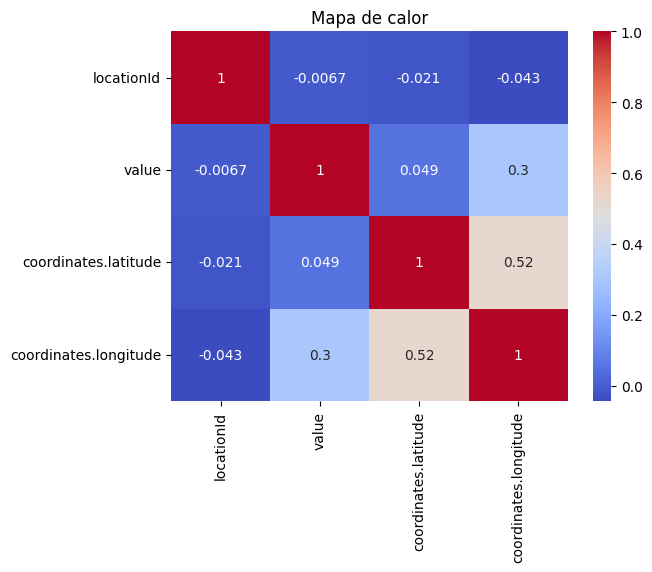

In [36]:
# Mapa de calor de la matriz de correlación
sns.heatmap(correlacion, annot=True, cmap='coolwarm')
plt.title('Mapa de calor')
plt.show()

Como se puede obtservar, la columna value posee datos que se encuentran fuera de los bigotes del boxplot, por tanto, se concluye que hay registros outliers.

Para visualizar el resumen de la distribución  de la correlación por cada columna utilizamos en este caso el plot dando la propiedad box de esta forma "kind= 'box'", en este caso, se utiliza el resumen para detectar los outliers.

Vamos a realizar el mismo análisis multivariable pero ahora de las columnas con tipo de datos diferentes al númerico. Como alternativa para realizar la correlación y mostrarla en un único mapa de calor, se utiliza el algoritmo de creamers de la biblioteca scipy.stats. Para la implementación del método de cramers se tomo el artículo de Nik. (n.d.) en donde da la solución que se adecua a nuestro conjunto de datos.
Según Cramér (1946), el algoritmo permite generar una medida para determinar la fuerza en la relación de variables categóricos.

In [37]:
import numpy as np
from scipy.stats import chi2_contingency
columnas_categoricas = datos
# Función para calcular el coeficiente de Cramér
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Selección de columnas categóricas
columnas_categoricas = datos.select_dtypes(exclude=['number', 'int64', 'float64']).columns

# Muestreo del conjunto de datos para reducir el uso de memoria
datos_muestra = datos.sample(n=1000, random_state=42)

# Crear una matriz vacía para almacenar los coeficientes de Cramér
matriz_cramer = pd.DataFrame(index=columnas_categoricas, columns=columnas_categoricas)

# Calcular el coeficiente de Cramér para cada par de columnas categóricas
for col1 in columnas_categoricas:
    for col2 in columnas_categoricas:
        if col1 != col2:
            matriz_cramer.loc[col1, col2] = cramers_v(datos_muestra[col1], datos_muestra[col2])
        else:
            matriz_cramer.loc[col1, col2] = 1.0  # La correlación consigo misma es 1

# Convertir a tipo float
matriz_cramer = matriz_cramer.astype(float)

matriz_cramer

,location,parameter,unit,country,entity,sensorType,date.utc,date.local
location,1.000000,0.855163,0.874678,0.980186,0.978220,0.978220,0.101874,0.101874
parameter,0.855163,1.000000,0.745367,0.507458,0.000000,0.000000,0.000000,0.000000
unit,0.874678,0.745367,1.000000,0.678512,0.000000,0.000000,0.000000,0.000000
country,0.980186,0.507458,0.678512,1.000000,0.091117,0.091117,0.092083,0.092083
entity,0.978220,0.000000,0.000000,0.091117,1.000000,0.498746,0.122597,0.122597
sensorType,0.978220,0.000000,0.000000,0.091117,0.498746,1.000000,0.122597,0.122597
date.utc,0.101874,0.000000,0.000000,0.092083,0.122597,0.122597,1.000000,1.000000
date.local,0.101874,0.000000,0.000000,0.092083,0.122597,0.122597,1.000000,1.000000


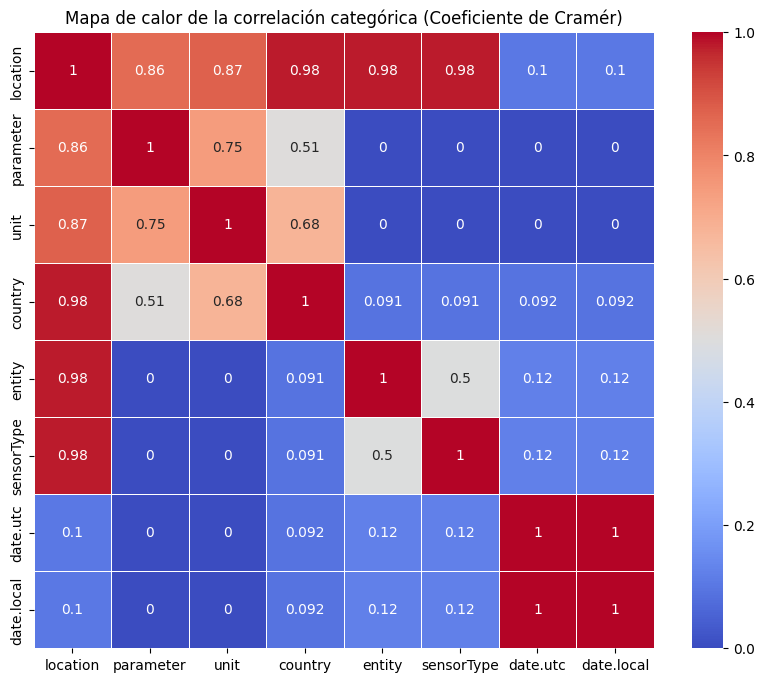

In [38]:
# Visualizar la matriz de correlación categórica con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_cramer, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de calor de la correlación categórica (Coeficiente de Cramér)')
plt.show()

####Análisis Univariable####

Se realiza un análisis univariable para resumir las tendencias y presencias en los valores atípicos.

Primero se realiza el análisis de las variables de tipo númericos, para esto se utiliza "matplotlib.pypl" para poder visualizar los gráficos en un uníco "show()".

<Figure size 1500x1500 with 0 Axes>

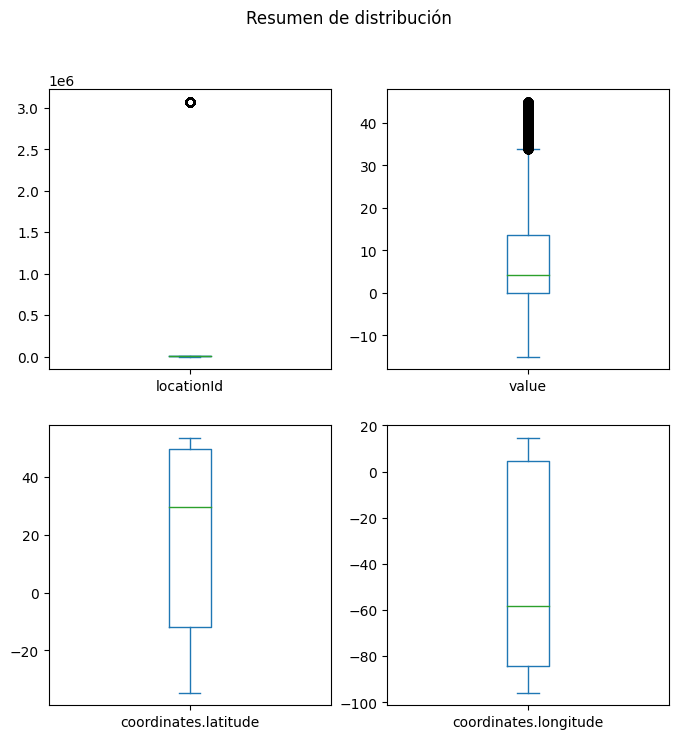

In [39]:
plt.figure(figsize=(15, 15))
df_numerico.plot(kind='box', subplots=True, layout=(int(len(df_numerico.columns)/2), 2), figsize=(8, 8), title='Resumen de distribución')
plt.show()

Ahora se procede a obtener la distribución de las columnas categoricas tomando en cuenta los registros con mayor presencia en el conjunto de datos.

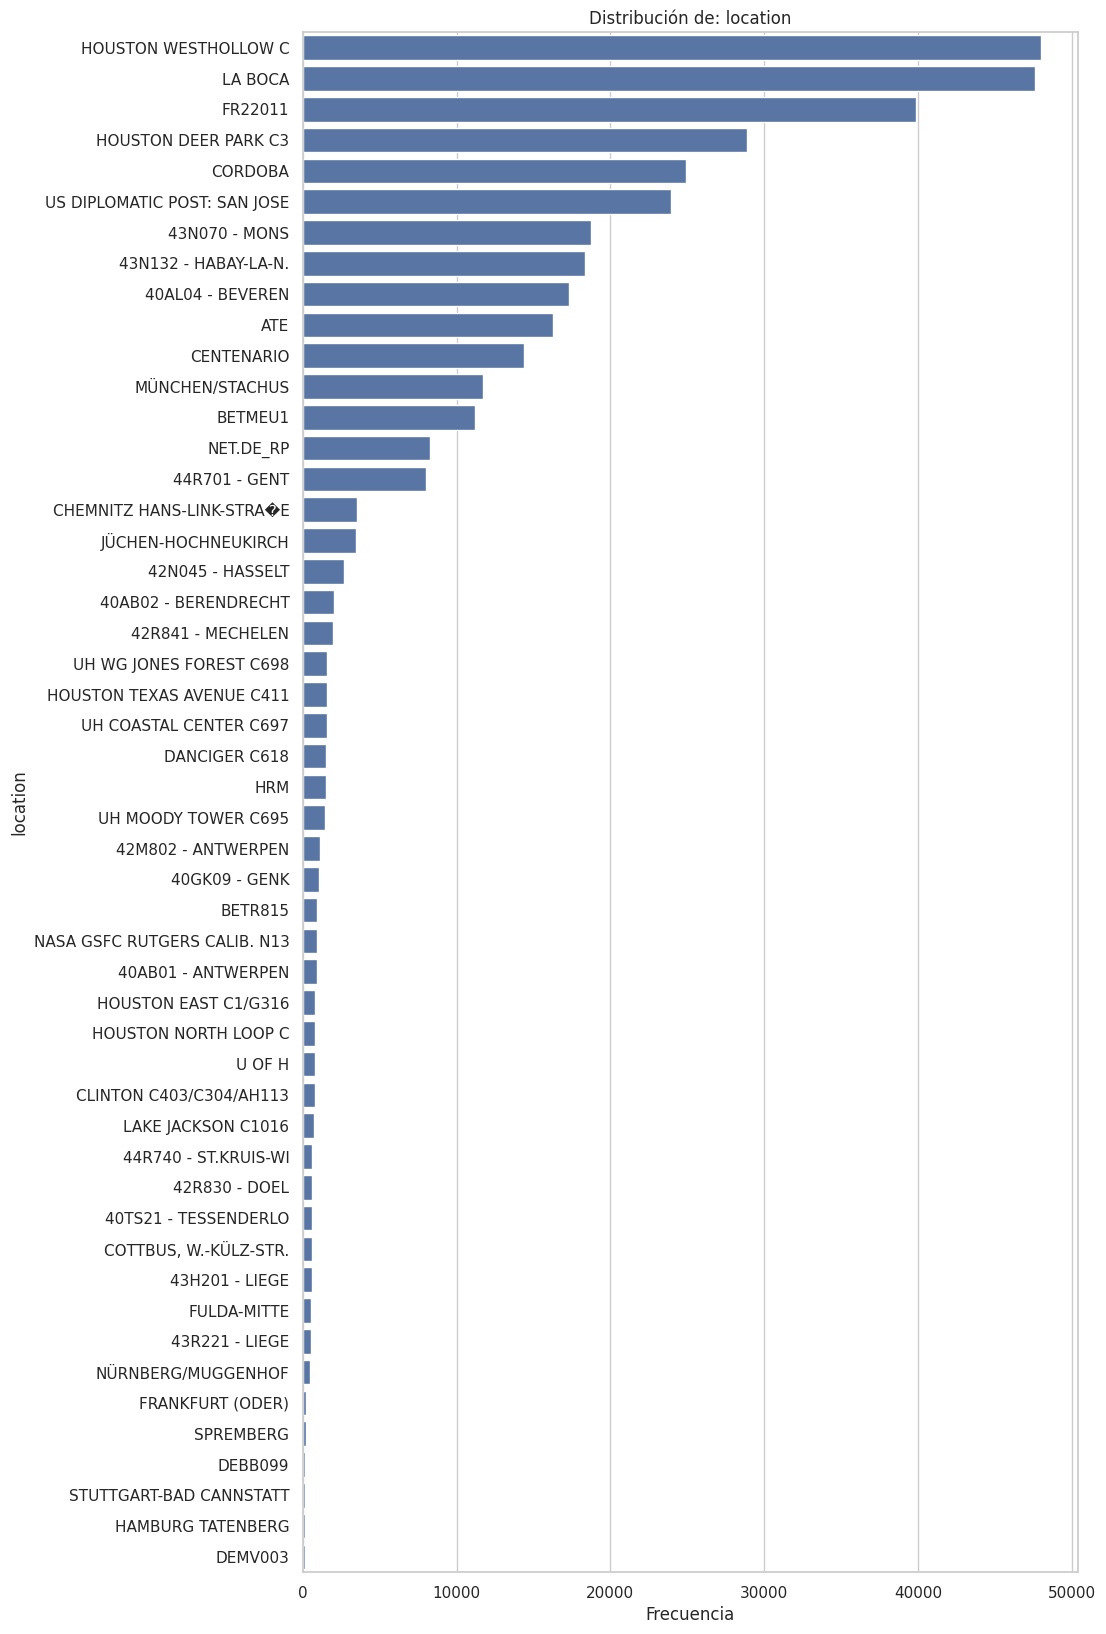

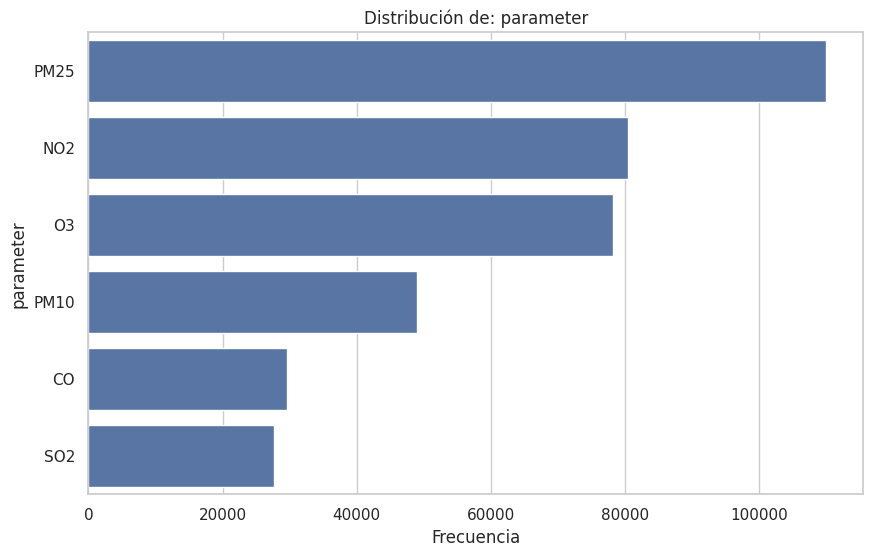

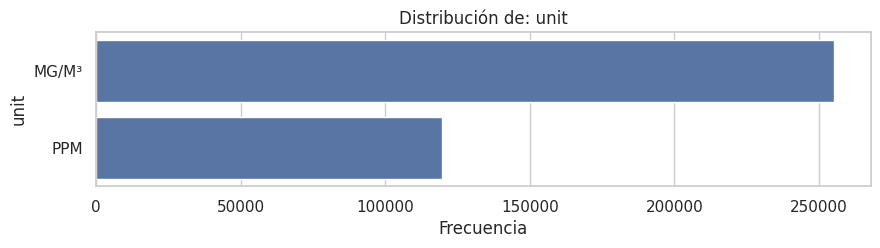

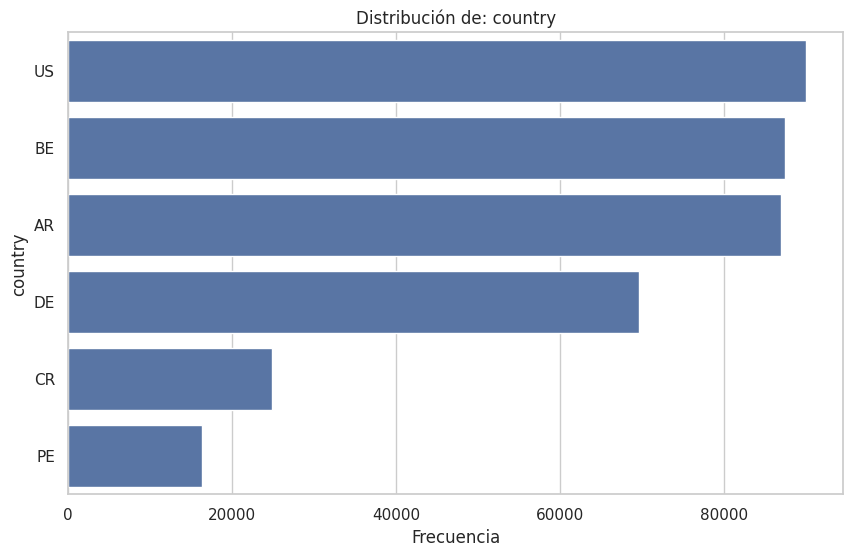

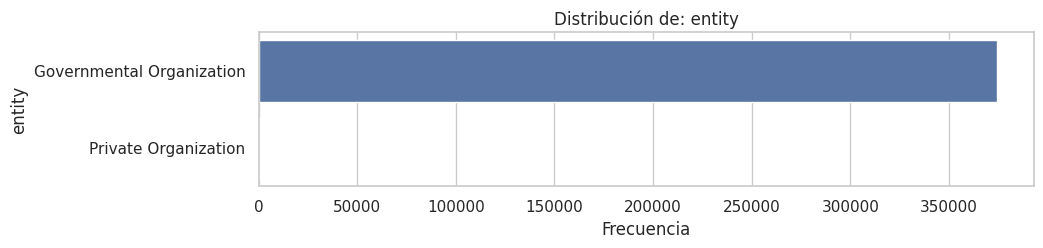

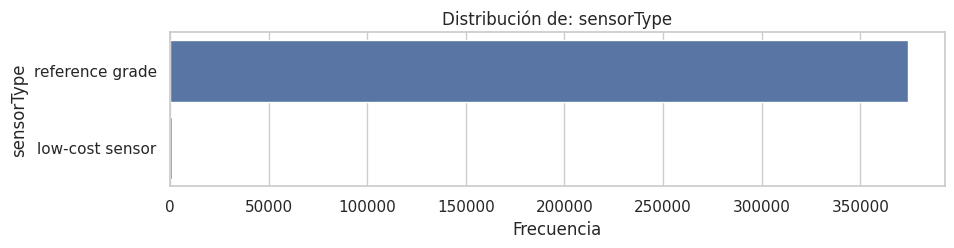

In [40]:
# Omitir las columnas 'date.utc' y 'date.local' ya son columnas de fecha y no es necesario analizar su distribución
columnas_categoricas = [col for col in columnas_categoricas if col not in ['date.utc', 'date.local']]

# Configurar el tema de Seaborn
sns.set_theme(style="whitegrid")

# Graficar la distribución de las variables categóricas más frecuentes
for col in columnas_categoricas:
    cols = datos[col].nunique()
    if cols > 15:
            cols = 20

    plt.figure(figsize=( 10, cols))
    sns.countplot(y=col, data=datos, order=datos[col].value_counts().index)
    plt.title(f'Distribución de: {col}')
    plt.ylabel(col)
    plt.xlabel('Frecuencia')
    plt.show()


###Distribución de los contaminantes comunes del aire por país###

Este gráfico de dispersión muestra cómo se distribuyen varios contaminantes comunes del aire en diferentes países. Cada punto en el gráfico representa un valor específico de un contaminante en un país determinado. Los puntos están coloreados según el país, lo que facilita la comparación entre ello.

Eliminamos las variables irrelevantes y definimos los paises del conjunto de datos.

In [41]:
datos_analisis = datos.copy()
datos_analisis = datos_analisis.dropna(subset=['locationId', 'location', 'unit', 'date.local', 'coordinates.latitude', 'coordinates.longitude'])
countries = datos_analisis['country'].unique()

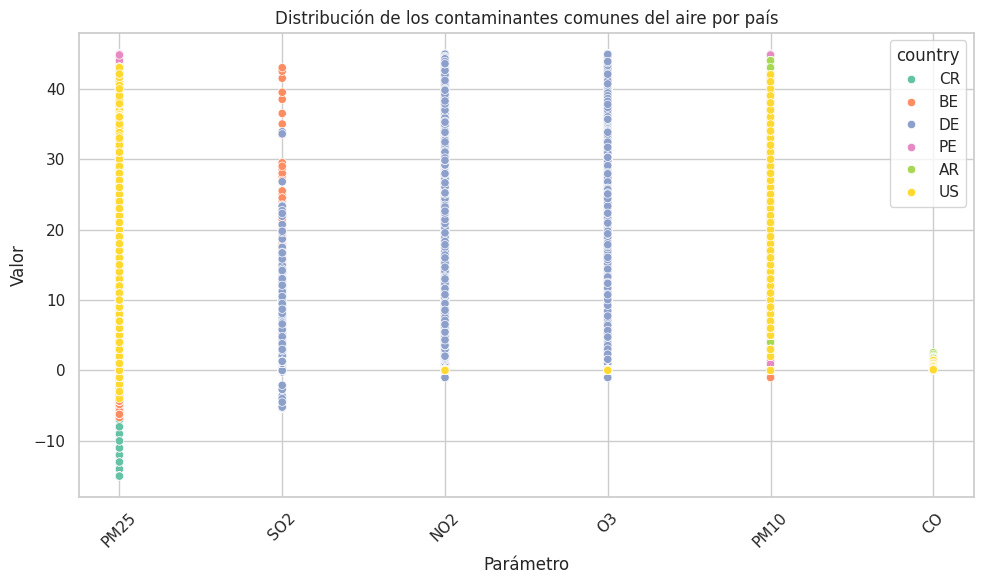

In [49]:

# Configura el tamaño de la figura del gráfico
plt.figure(figsize=(10, 6))

# Crea un gráfico de dispersión con los datos del DataFrame 'df'
# 'x' es el eje horizontal (parámetro), 'y' es el eje vertical (valor)
# 'hue' colorea los puntos según el país, 'palette' define la paleta de colores
sns.scatterplot(x="parameter", y="value", hue="country", data=datos_analisis, palette="Set2")

# Añade un título al gráfico
plt.title("Distribución de los contaminantes comunes del aire por país")
plt.xlabel("Parámetro")# Etiqueta el eje x
plt.ylabel("Valor")# Etiqueta el eje y
plt.xticks(rotation=45)# Rota las etiquetas del eje x 45 grados para mejor legibilidad
plt.tight_layout()# Ajusta el diseño del gráfico para que los elementos no se superpongan

plt.show()# Muestra el gráfico

###Análisis de tendencia del contaminante PM2.5 por país###

Se realiza el análisis de tendencia de los valores de PM2.5, un contaminante común del aire, para diferentes países a lo largo de los años.


Se convierte las fechas a un formato adecuado y filtra los datos para incluir solo los valores de PM2.5. Luego, agrupa los datos por país y año para generar gráficos de líneas que muestran cómo han cambiado los niveles de PM2.5 a lo largo del tiempo en cada país.

In [43]:
# Crear un gráfico de líneas para cada país
# countries = ['CR', 'BE', 'DE', 'PE', 'AR', 'US']  # Costa Rica, Bélgica, Alemania, Perú, Argentina, Estados Unidos

datos_pm25 = datos_analisis[datos_analisis['parameter'] == 'PM25'].copy()# Filtrar los datos para el parámetro PM2.5

datos_pm25['date.utc'] = pd.to_datetime(datos_pm25['date.utc'])# Convertir la columna 'date.utc' a tipo datetime
datos_pm25['year'] = datos_pm25['date.utc'].dt.year# Obtener el año de la columna 'date.utc' y asignarlo a una nueva columna 'year'

datos_agrupados = datos_pm25.groupby(['country', 'year']).count().reset_index()# Agrupar los datos por país y año



Se genera el grádico de líneas con "matplotlib.pyplot" recorriendo en un for cada país del dataset. Si no hay datos de PM2.5 disponibles para un país en particular, se imprime un mensaje indicando esta ausencia.

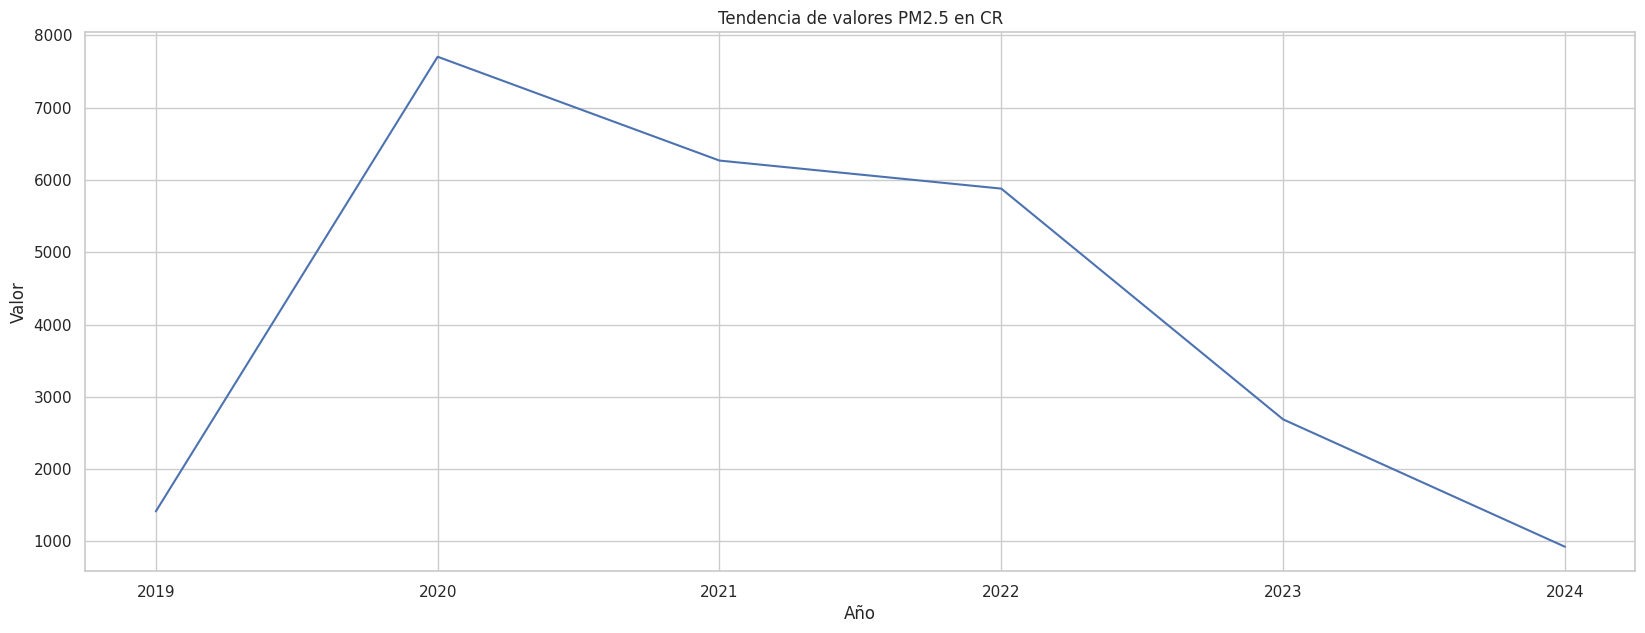

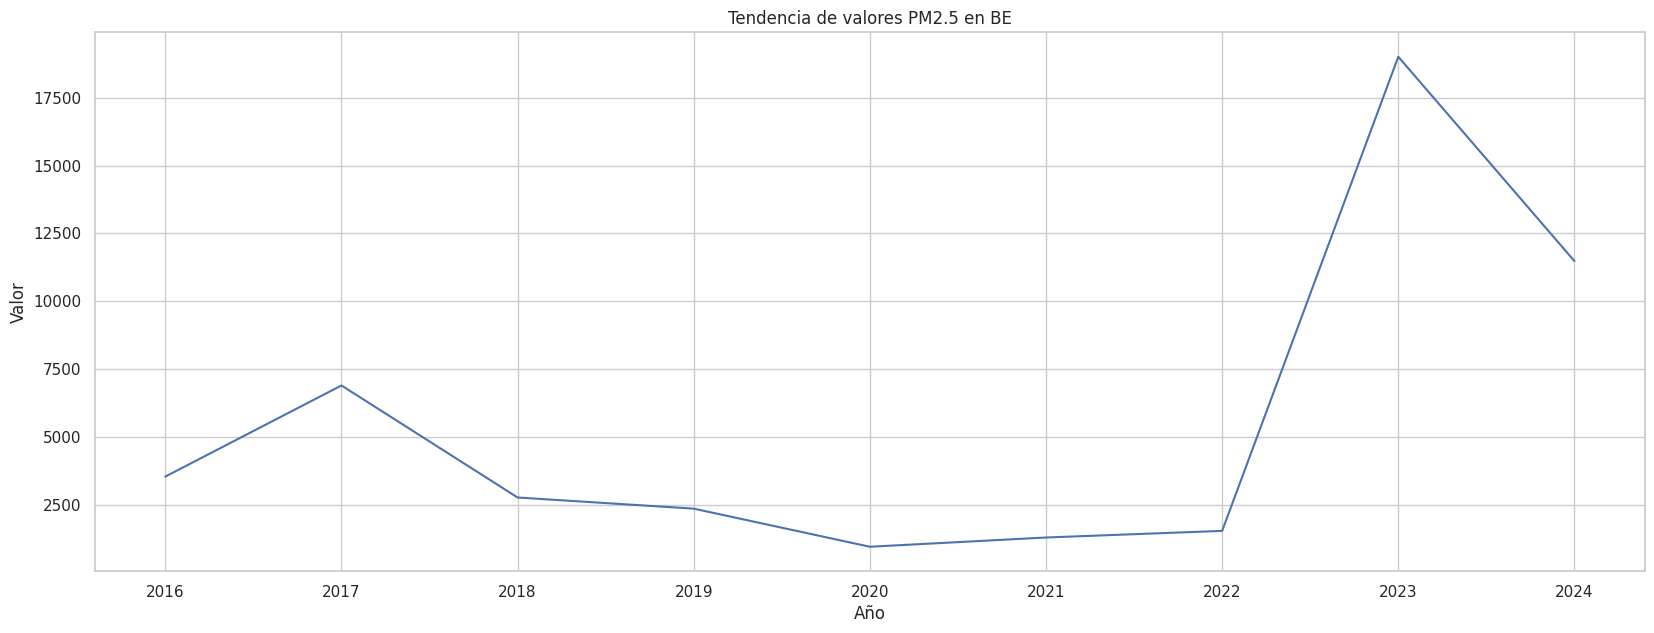

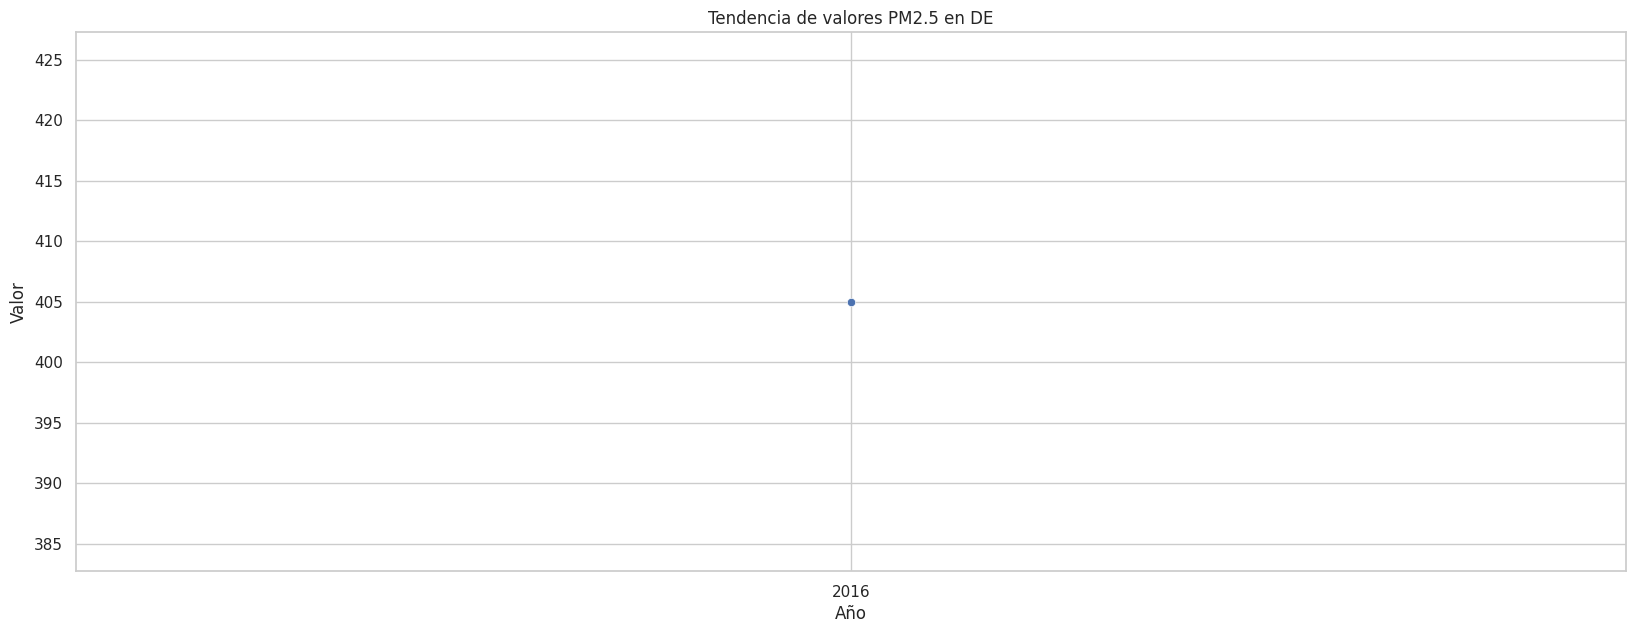

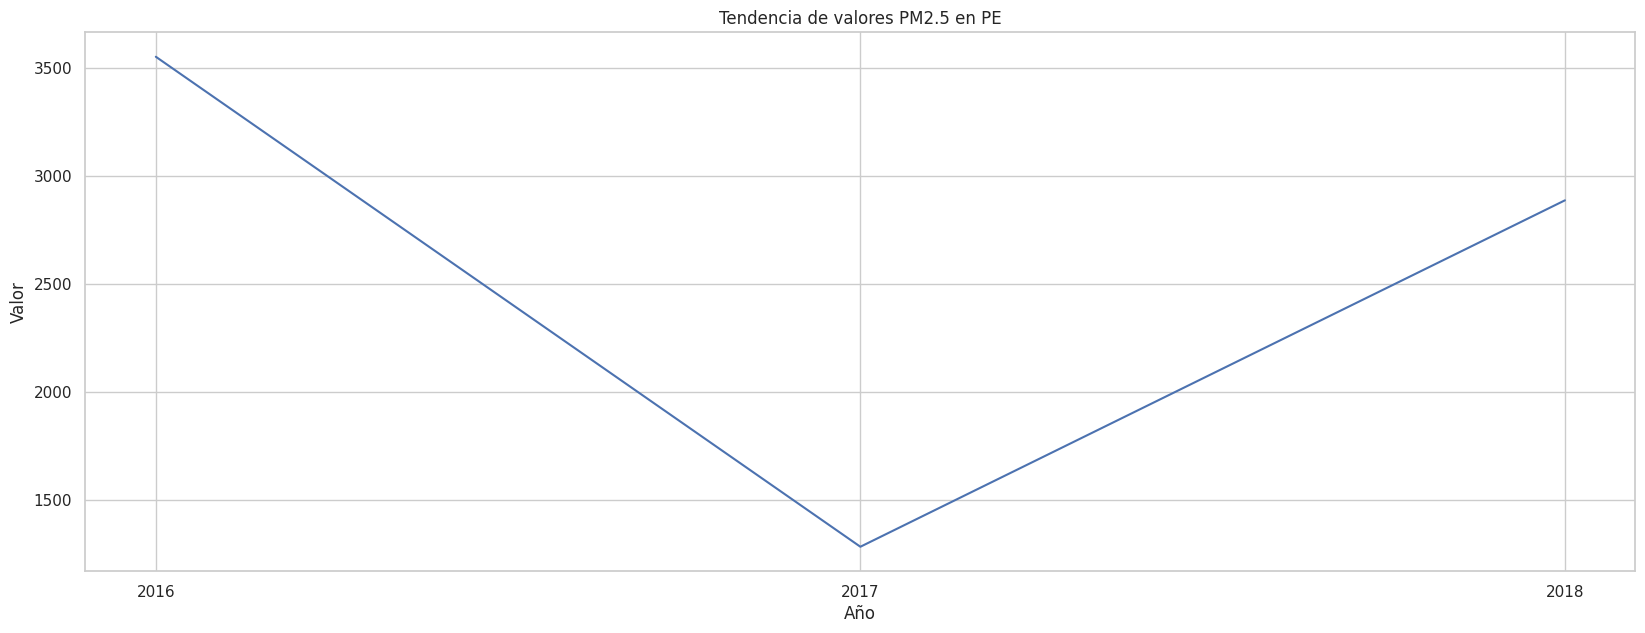

No hay datos disponibles para AR.


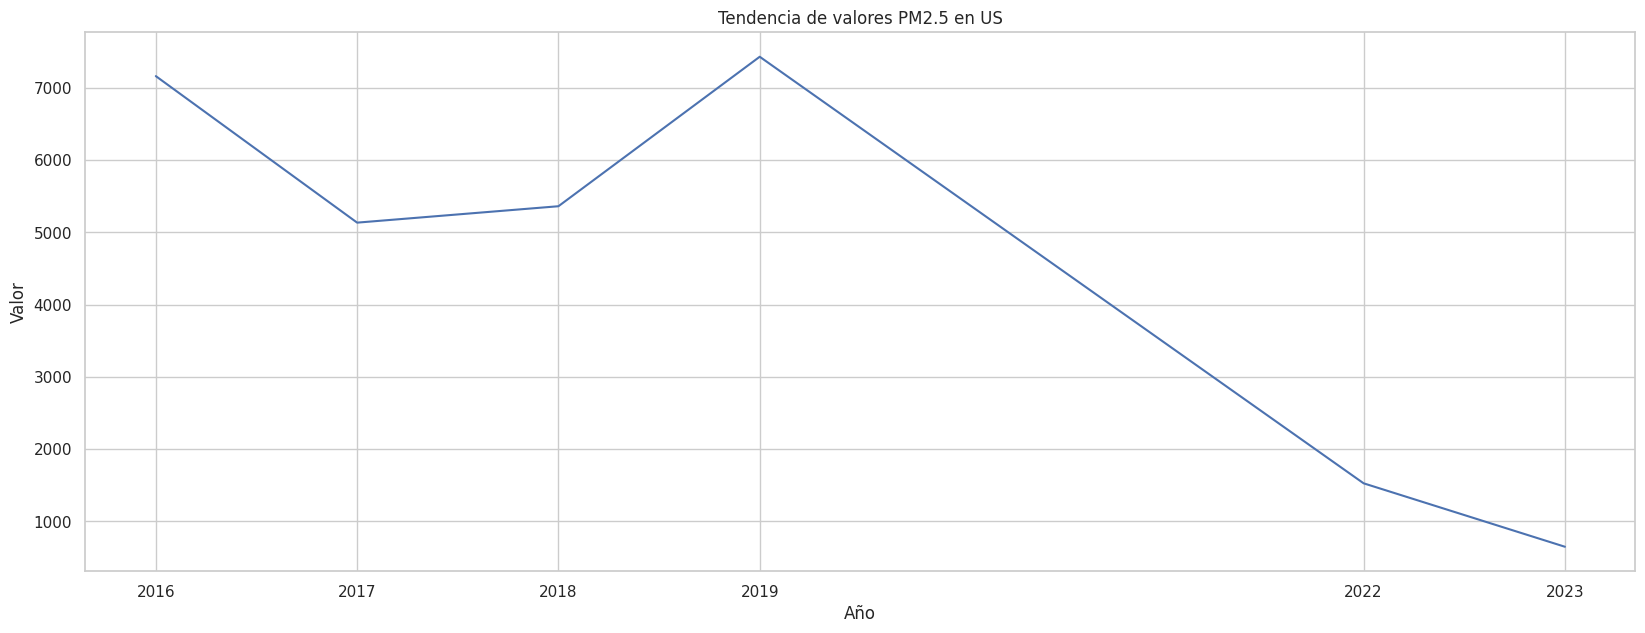

In [44]:
# Crear un gráfico de líneas para cada país
# countries = ['CR', 'BE', 'DE', 'PE', 'AR', 'US']  # Costa Rica, Bélgica, Alemania, Perú, Argentina, Estados Unidos

# Iterar sobre la lista de países
for country in countries:
    if country in datos_agrupados['country'].unique(): # Verificar si hay datos disponibles para el país actual
        plt.figure(figsize=(20, 7))  # Crear una nueva figura para el gráfico
        country_data = datos_agrupados[datos_agrupados['country'] == country]# Filtrar los datos para el país actual
        if len(country_data) > 1: # Verificar si hay más de un año de datos
            sns.lineplot(data=country_data, x='year', y='value') # Crear un gráfico de líneas para los datos del país actual
        else:
            sns.scatterplot(data=country_data, x='year', y='value') # Crear un gráfico de puntos si solo hay un año de datos

        plt.title(f'Tendencia de valores PM2.5 en {country}')# Añadir un título y etiquetas a los ejes
        plt.xlabel('Año')
        plt.ylabel('Valor')
        plt.xticks(ticks=country_data['year'], labels=country_data['year'].astype(int))# Asegurarse de que el eje x trate los años como categorías discretas


        plt.show()# Mostrar el gráfico
    else:# Imprimir un mensaje si no hay datos disponibles para el país actual
        print(f"No hay datos disponibles para {country}.")


###Distribución de los contaminantes comunes del aire en cada país###


Para para visualizar a detalle los contaminantes comunes de cada país seleccionado, se utiliza un gráfico de barras que agrupa por páis cada medida/valor y cada parámetro del tipo de contaminante.

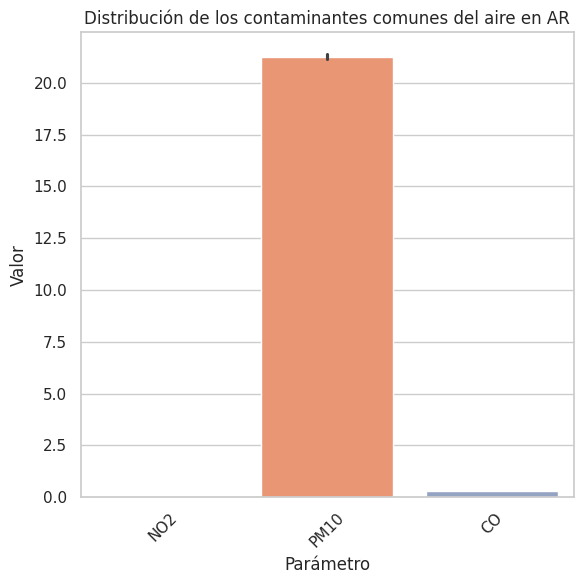

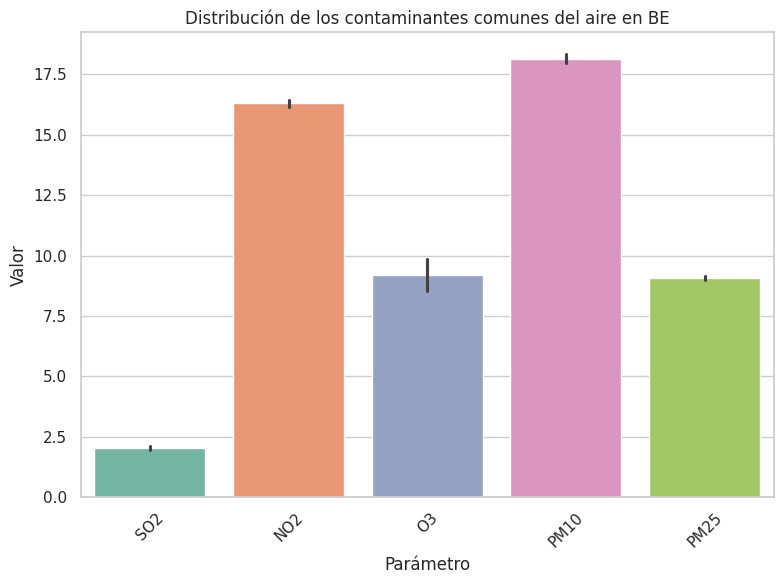

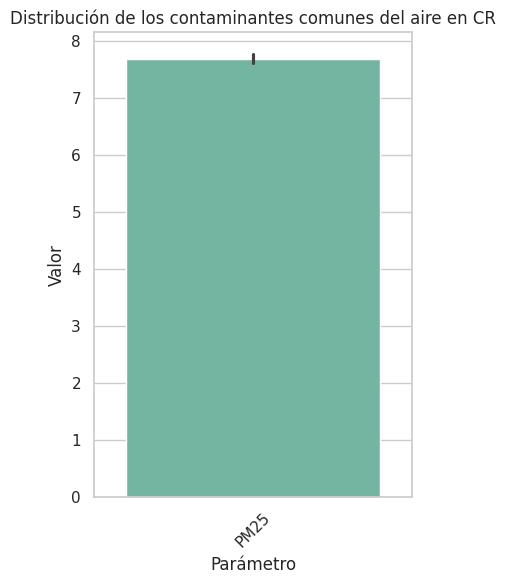

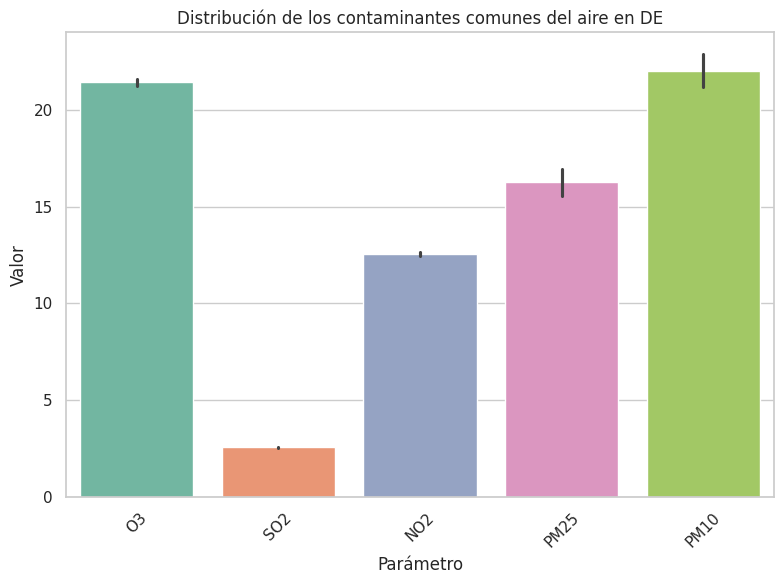

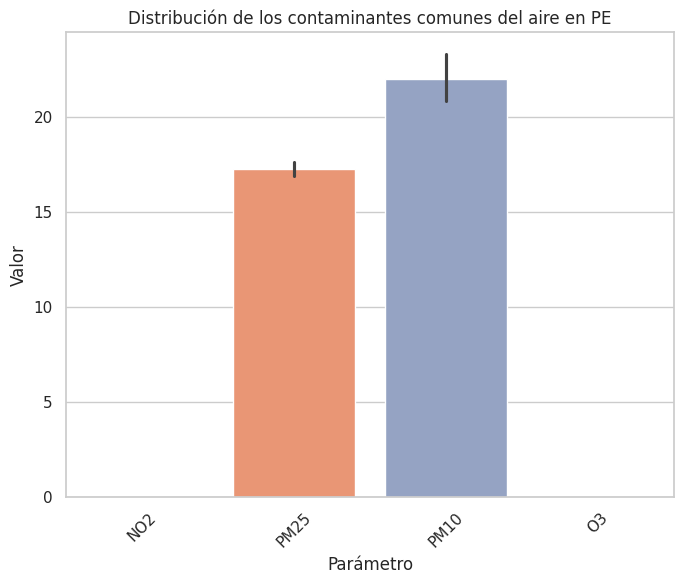

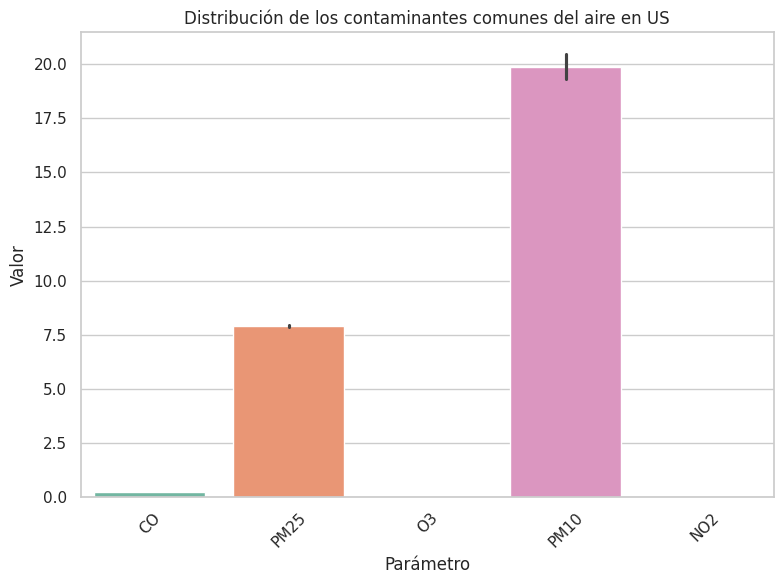

In [45]:
datos_pais = datos_analisis.groupby('country')# Agrupa los datos por país

# Itera sobre cada grupo (país) en el DataFrame agrupado
# 'country' es el nombre del país y 'country_data' es el subconjunto de datos para ese país
for country, country_data in datos_pais:
    # Calcula estadísticas descriptivas para el país actual
    summary = country_data['value'].describe()

    # Crea un gráfico de barras para el país actual
    plt.figure(figsize=(country_data['parameter'].nunique() + 3, 6))#Configura el tamaño de la figura del gráfico segun la cantidad de parametros
    sns.barplot(x="parameter", y="value", data=country_data, palette="Set2",hue="parameter")# Crea un gráfico de barras

    # Añade un título y etiquetas a los ejes
    plt.title(f"Distribución de los contaminantes comunes del aire en {country}")
    plt.xlabel("Parámetro") # Etiqueta el eje x
    plt.ylabel("Valor")# Etiqueta el eje y
    plt.xticks(rotation=45) # Rota las etiquetas del eje x 45 grados para mejor legibilidad
    plt.tight_layout()# Ajustar el diseño del gráfico para que los elementos no se superpongan
    plt.show()# Muestra el gráfico


## Conclusiones

En este estudio, se analizaron los datos de contaminantes comunes del aire en seis países (Argentina, Costa Rica, Alemania, Estados Unidos, Bélgica y Perú) durante el período de 2014 a 2024.

Según el grafico de dispersión, se revelo diferencias significativas en los niveles de contaminación entre los 6 países. Por ejemplo, Estados Unidos se destacó por tener los niveles más altos de contaminación por PM2.5 y PM1.0, lo que indica una mayor presencia de partículas finas en el aire. Alemania mostró altos niveles de contaminantes como SO2, NO2 y O3, reflejando una diversidad de fuentes de contaminación. Argentina y Perú fueron los países con menor contaminación en el período analizado, sugiriendo una mejor calidad del aire en comparación con los otros países.

El análisis de tendencia del contaminante PM2.4 mostro un aumento del contaminante en Costa Rica durante el período de la pandemia de COVID-19, lo que podría estar relacionado con cambios en las actividades humanas durante ese tiempo. En Bélgica, los niveles de PM2.4 aumentaron considerablemente a partir de 2022, lo que podría indicar un cambio en las fuentes de contaminación o en las condiciones ambientales. Mientras que, en Perú, los niveles de PM2.4 disminuyeron en 2017 pero volvieron a aumentar en 2018, mostrando una variabilidad en la calidad del aire. Por último, en Estados Unidos se registró una disminución significativa de PM2.4 desde 2022, lo que sugiere mejoras en las políticas de control de la contaminación o en las prácticas industriales

La distribución de contaminantes entre cada país indico que, en Argentina, Costa Rica y Perú no se detectaron niveles significativos de NO2, O3 y SO2 durante el período analizado, lo que podría indicar una menor industrialización o mejores prácticas ambientales. Por otro lado, en Alemania, Estados Unidos y Bélgica se encontraron casi todos los contaminantes comunes, reflejando una mayor diversidad de fuentes de contaminación y una mayor industrialización.

Este análisis proporciona una visión integral de la calidad del aire en los seis países, destacando tanto las diferencias como las similitudes en los niveles y tipos de contaminantes presentes. Estos hallazgos pueden ser útiles para desarrollar políticas ambientales más efectivas y para comprender mejor las dinámicas de la contaminación del aire a nivel global.


# Referencias

Castrillo, M. (2023, septiembre 13). *Cómo identificar y tratar outliers con Python.* Medium. https://medium.com/@martacasdelg/c%C3%B3mo-identificar-y-tratar-outliers-con-python-bf7dd530fc3

Cramér, H. (1946). Mathematical Methods of Statistics. Princeton University Press.

Guzman, M. (2022, 23 de mayo). *Guía para limpiar datos con Pandas*. Medium. https://medium.com/nowports-tech/guia-limpiar-datos-con-pandas-3dc634c47e11

Kenneth Reitz. (s.f.). *Requests: HTTP for humans (Version 2.16.0)* [Computer software]. PyPI. https://pypi.org/project/requests/2.16.0/

Nik. (n.d.). How to Calculate Cramer’s V in Python. datagy.io1. Retrieved September 22, 2024, from https://datagy.io/cramers-v-python/
OpenAQ. (s.f.). Introduction. OpenAQ API Documentation. https://docs.openaq.org/docs/introduction

Python Software Foundation. (s.f.). *urllib.parse — Parse URLs into components. Python 3.9.9 documentation*. https://docs.python.org/3/library/urllib.parse.html

Rcurioso (s.f.). *Limpeza de datos en Python con Pandas* [Python Notebook]. Kaggle. https://www.kaggle.com/code/rcurioso/limpeza-datos-python-pandas

The pandas development team. (2024). *pandas.DataFrame — pandas 2.1.1 documentation.* https://pandas.pydata.org/docs/reference/frame.html








